demo for class


### import (colab ver)

In [ ]:
# import os
# import torch
# import itertools
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch-geometric
# !pip3 install kmeans1d
# from torch_geometric.data import Data
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch_geometric.transforms as T
# import sys
# import random
# import numpy as np
# import time
# import math
# import csv
# import datetime
# import math
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import pandas as pd
# import glob
# import random
# import torch.nn as nn
# import torch.optim as optim
# from collections import defaultdict
# from tqdm.notebook import tqdm
# from math import exp
# from chardet import detect
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.utils import degree
# from sklearn import preprocessing as pp
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import scipy.sparse as sp
# from networkx.algorithms import bipartite
# import kmeans1d
# import copy
# from google.colab import drive

### import (local)

In [2]:
# --- 표준 라이브러리 ---
import os, sys, math, time, random, copy, glob, csv, datetime, itertools
from collections import defaultdict

# --- 과학 연산 / 시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp

# --- PyTorch & PyG ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

# --- 기타 ---
from tqdm import tqdm
from chardet import detect
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import bipartite
import kmeans1d

# --- Device 선택 (Apple Silicon M4) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# MPS 미지원 연산 자동 CPU fallback 허용
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("Using device:", device)

Using device: mps


In [12]:
# hyperparameters
latent_dim = 128   # length of user/item embedding
num_layer = 3   # num.hop neighbor
rating_threshold = 7
batch_size = 500
epochs = 1000
learning_rate = 0.001
decay = 0.0001
topK = 3 # num. top recommend
dropout = 0.2
sample_rate = 0.2  # test size, train whole set

df = pd.read_csv('joke.csv')   #('movielens.csv')
print("*"*50)
print("Original dataset info.")
user_ids = sorted(df['userId'].unique())
item_ids = sorted(df['jokeId'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of jokes = ", len(item_ids))
print("  Number of ratings = ", len(df))
print("*"*50)
print("After rating filtering")
print("  Rating threshhold = ", rating_threshold)
# df = df[df['rating']>=rating_threshold]  # consider only rating >= threshold
user_ids = sorted(df['userId'].unique())
item_ids = sorted(df['jokeId'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of jokes = ", len(item_ids))
print("  Number of ratings = ", len(df))

**************************************************
Original dataset info.
  Number of users =  906
  Number of jokes =  140
  Number of ratings =  38217
**************************************************
After rating filtering
  Rating threshhold =  7
  Number of users =  906
  Number of jokes =  140
  Number of ratings =  38217


<positron-console-cell-13>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-13>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


LightGCN link prediction


100%|██████████| 1000/1000 [15:28<00:00,  1.08it/s]

            5          7          8    ...       148       149       150
1      3.653611   7.702445   7.315797  ...  0.124971 -0.717637 -0.569049
2     10.641576   9.909795   6.567024  ... -0.060785  0.898134 -1.025680
3      9.948985   5.998505  10.464510  ...  1.538558  0.164748  2.613968
4      9.992289   9.689819   9.579341  ...  0.163365  0.067687  0.281082
5      9.243557  10.134841   6.296590  ... -0.664855 -0.733859 -1.518144
...         ...        ...        ...  ...       ...       ...       ...
994    3.987669   4.125751  10.545654  ...  0.799034  0.673097  1.935262
995    4.021508  10.987267  10.256804  ...  3.719786  2.513164  3.417390
996    0.865128   6.268997   2.688481  ...  7.941468  8.442122  5.761922
997   -0.908199   8.434783   3.662611  ... -0.687086  2.408251  1.971491
1000   2.204930   9.210830   4.681299  ...  7.786970  4.456367  3.788949

[906 rows x 140 columns]


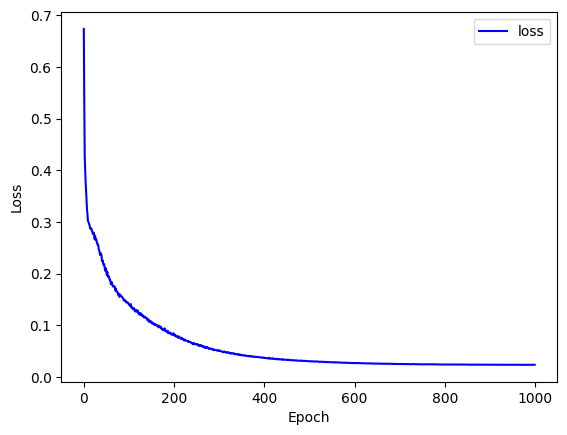

In [13]:
rand_indices = np.random.permutation(range(df.shape[0]))
train_size = math.ceil(len(df)*(1-sample_rate))
df_train = df.iloc[rand_indices[:train_size]]
df_test = df.iloc[rand_indices[train_size:]]

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df_train['user_idx'] = le_user.fit_transform(df_train['userId'].values)
df_train['item_idx'] = le_item.fit_transform(df_train['jokeId'].values)
df_train = df_train.sort_values(by=['userId', 'jokeId'], ascending=[True, True])
user_ids = sorted(df_train['userId'].unique())
item_ids = sorted(df_train['jokeId'].unique())
num_user = len(user_ids)
num_item = len(item_ids)

def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + posEmb0.norm().pow(2) + negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss


def data_loader(data, batch_size, n_usr, n_itm):
    interected_items_df = data.groupby('user_idx')['item_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns = ['users'])
    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_idx', right_on = 'users')
    pos_items = interected_items_df['item_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)


class LightGCN(nn.Module):
    def __init__(self, data, n_user, n_item, n_layers, latent_dim=32):
        super(LightGCN, self).__init__()
        print("LightGCN link prediction")
        self.data = data
        self.num_user = n_user
        self.num_item = n_item
        self.num_layer = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.num_user + self.num_item, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.num_user, self.num_item), dtype = np.float32)
        R[self.data['user_idx'], self.data['item_idx']] = 1.0

        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: self.num_user, self.num_user :] = R
        adj_mat[self.num_user :, : self.num_user] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape
        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor


    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.num_layer):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.num_user, self.num_item])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.num_user, self.num_item])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed


    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0


# train model
model = LightGCN(df_train, num_user, num_item, num_layer, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list_epoch = []
for epoch in tqdm(range(epochs)):
    n_batch = int(len(df_train)/batch_size)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    model.train()
    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(df_train, batch_size, num_user, num_item)
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.forward(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = decay * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    model.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = model.propagate_through_layers()

    loss_list_epoch.append(round(np.mean(final_loss_list),4))


score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
df_score = pd.DataFrame(score, index=user_ids, columns = item_ids)
print(df_score)


# loss graph
losses_np = np.array(loss_list_epoch)
epoch_range = np.arange(1,epochs)
plt.plot(losses_np, color='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import kmeans1d
import numpy as np
import pandas as pd

# 1. jokeId와 jokeText가 매핑된 데이터를 미리 준비합니다.
# 'jester_items.csv' 파일이 필요합니다.
try:
    joke_text_df = pd.read_csv('jester_items.csv')
    # jokeId를 key로, jokeText를 value로 하는 딕셔너리 생성
    joke_id_to_text = pd.Series(joke_text_df.jokeText.values, index=joke_text_df.jokeId).to_dict()
except FileNotFoundError:
    print("오류: 'jester_items.csv' 파일을 찾을 수 없습니다. 농담 내용을 불러오려면 이 파일이 필요합니다.")
    joke_id_to_text = {}


def user_info(user, df_train, df_score, joke_ids):
    """
    특정 사용자에 대해 각 농담별 평점 예측치와 이미 평가했는지 여부를 리스트로 반환합니다.
    """
    list_select = []
    list_score = []
    
    for joke in joke_ids:
        list_score.append(df_score.loc[user][joke])
        if not df_train[(df_train['userId'] == user) & (df_train['jokeId'] == joke)].empty:
            list_select.append(1)
        else:
            list_select.append(0)
            
    return list_select, list_score

print("*"*50)
print("\n  사용자별 추천 목록 생성 (User ID: 1, 2, 3)")
print("*"*50)

# 학습 데이터에 존재하는 모든 joke_id를 가져옵니다.
all_trained_joke_ids = sorted(df_train['jokeId'].unique())
all_trained_user_ids = sorted(df_train['userId'].unique())

# 2. 결과를 보고 싶은 특정 사용자 ID 목록
target_user_ids = [99999]
# target user가 학습 데이터에 존재하는지 확인
users_to_recommend = [u for u in target_user_ids if u in all_trained_user_ids]

for u in users_to_recommend:
    print(f"\n----- 🕵️ User ID: {u} 님을 위한 추천 -----")
    
    list_select, list_score = user_info(u, df_train, df_score, all_trained_joke_ids)
    
    clusters, centroids = kmeans1d.cluster(list_score, 2)
    recommend_cluster_id = np.argmax(centroids)

    recom_new_jokes = []
    
    for i in range(len(clusters)):
        if clusters[i] == recommend_cluster_id:
            joke_id = all_trained_joke_ids[i]
            # 아직 평가하지 않은 농담만 추천 목록에 추가
            if list_select[i] == 0:
                # 3. jokeId를 이용해 실제 jokeText를 찾아 추가합니다.
                joke_text = joke_id_to_text.get(joke_id, f"Joke ID {joke_id}의 내용을 찾을 수 없습니다.")
                recom_new_jokes.append(joke_text)
    
    # 결과 출력
    if recom_new_jokes:
        print(f"  ✅ 새로운 추천 농담 ({len(recom_new_jokes)}개):")
        # 4. 농담 내용을 하나씩 줄바꿈하여 보여줍니다.
        for idx, joke in enumerate(recom_new_jokes, 1):
            print(f"    {idx}. {joke.strip()}")
    else:
        print("  🤔 새로운 추천 농담을 찾지 못했습니다.")

**************************************************

  사용자별 추천 목록 생성 (User ID: 1, 2, 3)
**************************************************

----- 🕵️ User ID: 2 님을 위한 추천 -----
  ✅ 새로운 추천 농담 (6개):
    1. Q. Did you hear about the dyslexic devil worshiper? 

A. He sold his soul to Santa.
    2. A dog walks into Western Union and asks the clerk to send a telegram. He fills out a form on which he
writes down the telegram he wishes to send: "Bow wow wow, Bow wow wow."

The clerk says, "You can add another 'Bow wow' for the same price."

The dog responded, "Now wouldn't that sound a little silly?"
    3. Clinton returns from a vacation in Arkansas and walks down  the
steps of Air Force One with two pigs under his arms.  At the bottom
of the steps, he says  to the honor guardsman, "These are genuine
Arkansas Razor-Back Hogs.  I got this one for Chelsea and this one for
Hillary."  

The guardsman replies, "Nice trade, Sir."
    4. A man arrives at the gates of heaven. St. Peter asks, "Religion?"

In [15]:
# df_score가 계산된 바로 다음에 이 코드를 추가하세요.

print("\n" + "*"*50)
print("  모델 성능 평가 (Accuracy & Satisfaction)")
print("*"*50)

# --- 1. 정확도 (RMSE) 계산 ---
actual_ratings = []
pred_ratings = []
errors = []

# 평가 데이터셋(df_test)을 한 줄씩 순회
for _, row in df_test.iterrows():
    user_id = row['userId']
    joke_id = row['jokeId']
    actual_rating = row['rating']
    
    # df_score에 해당 user/joke가 모두 존재하는 경우에만 계산 (오류 방지)
    if user_id in df_score.index and joke_id in df_score.columns:
        pred_rating = df_score.loc[user_id, joke_id]
        
        actual_ratings.append(actual_rating)
        pred_ratings.append(pred_rating)
        errors.append((pred_rating - actual_rating)**2)

if errors:
    mse = sum(errors) / len(errors)
    rmse = mse**0.5
    print(f"✅ 예측 정확도 (RMSE): {rmse:.4f}")
    print("   (0에 가까울수록 예측이 정확합니다.)")
else:
    print("⚠️ RMSE를 계산할 수 없습니다. 평가 데이터셋의 사용자가 학습 데이터에 없습니다.")


**************************************************
  모델 성능 평가 (Accuracy & Satisfaction)
**************************************************
✅ 예측 정확도 (RMSE): 4.5495
   (0에 가까울수록 예측이 정확합니다.)


In [16]:
from sklearn.metrics import ndcg_score

# --- 2. 만족도 (NDCG@10) 계산 ---
k = 10
ndcg_scores = []

# 평가 데이터에 있는 사용자들을 대상으로 한 명씩 평가
test_users = df_test['userId'].unique()

for user_id in test_users:
    if user_id not in df_score.index:
        continue

    # 사용자의 모든 예측 점수를 가져와 높은 순으로 정렬
    user_pred_ratings = df_score.loc[user_id].sort_values(ascending=False)
    
    # 사용자가 실제로 평가한 아이템과 평점 (정답셋)
    true_items = df_test[df_test['userId'] == user_id]
    
    # 예측 점수가 높은 상위 k개 아이템 선정
    top_k_items = user_pred_ratings.head(k)
    
    # scikit-learn의 ndcg_score를 사용하기 위해 형식 맞추기
    # true_relevance: 정답 평점 배열
    # pred_scores: 모델의 예측 점수 배열
    true_relevance = np.zeros((1, k))
    pred_scores = np.zeros((1, k))

    for i, (joke_id, pred_score) in enumerate(top_k_items.items()):
        pred_scores[0, i] = pred_score
        # 추천된 아이템이 실제 평가 목록에 있다면, 그 평점을 relevance 점수로 사용
        if joke_id in true_items['jokeId'].values:
            true_relevance[0, i] = true_items[true_items['jokeId'] == joke_id]['rating'].iloc[0]
            
    user_ndcg = ndcg_score(true_relevance, pred_scores, k=k)
    ndcg_scores.append(user_ndcg)

if ndcg_scores:
    avg_ndcg = np.mean(ndcg_scores)
    print(f"✅ 추천 만족도 (NDCG@{k}): {avg_ndcg:.4f}")
    print("   (1에 가까울수록 좋은 아이템을 상위에 추천합니다.)")
else:
    print("⚠️ NDCG를 계산할 수 없습니다.")

✅ 추천 만족도 (NDCG@10): 0.0558
   (1에 가까울수록 좋은 아이템을 상위에 추천합니다.)


In [6]:
def user_info(user, df_train, df_score, item_ids):
    list_select = []
    list_score = []
    print("\n user ", user)
    for i, v in enumerate(item_ids):
        list_score.append(df_score.loc[user][v])
        if ((df_train['userId']==user) & (df_train['jokeId']==v)).any():
            list_select.append(1)
        else:
            list_select.append(0)

    return list_select, list_score


print("*"*50)
print("\n  추천 목록")
recom_dic = {}
for u in user_ids:
    list_select, list_score = user_info(u, df_train, df_score, item_ids)
    list_recom, centroids = kmeans1d.cluster(list_score, 2)

    recom_ok = []
    recom_no = []
    for ir in range(len(list_recom)):
        if list_select[ir]==0 and list_recom[ir]==1:
            recom_ok.append(item_ids[ir])
            print("  buy",item_ids[ir])
        if list_select[ir]==1 and list_recom[ir]==0:
            recom_no.append(item_ids[ir])
            print("  sell",item_ids[ir])

    if len(recom_ok) > 0:
        print("  recommend buy ", len(recom_ok),"items")
    if len(recom_no) > 0:
        print("  recommend sell ", len(recom_no),"items")


**************************************************

  추천 목록

 user  1
  buy 53
  buy 62
  recommend buy  2 items

 user  2
  buy 16
  buy 19
  buy 27
  buy 31
  buy 32
  buy 34
  buy 42
  buy 50
  buy 54
  buy 56
  buy 63
  buy 66
  buy 69
  buy 76
  buy 93
  recommend buy  15 items

 user  5
  buy 27
  buy 68
  recommend buy  2 items

 user  6
  buy 7
  buy 17
  buy 18
  buy 26
  buy 27
  buy 32
  buy 34
  buy 42
  buy 44
  buy 45
  buy 47
  buy 48
  buy 49
  buy 50
  buy 63
  buy 65
  buy 66
  buy 68
  buy 69
  buy 76
  buy 81
  buy 83
  buy 89
  buy 91
  buy 109
  recommend buy  25 items

 user  7

 user  8
  buy 21
  buy 23
  buy 28
  buy 34
  buy 35
  buy 41
  buy 45
  buy 61
  buy 66
  buy 80
  buy 83
  buy 101
  buy 102
  buy 105
  recommend buy  14 items

 user  9

 user  10
  buy 49
  buy 117
  recommend buy  2 items

 user  11

 user  12

 user  13
  buy 102
  buy 104
  buy 108
  recommend buy  3 items

 user  15

 user  16

 user  17

 user  18
  buy 15
  buy 23
  buy 25
  b